<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Introduction to image similarity

Image similarity methods can be used to build Image Retrieval systems where, given a query image, the goal is to find all similar images in a reference set. These systems can be used e.g. on a shopping website to suggest related products.

In this tutorial we build an image retrieval system based on leveraging DNNs trained for image classification. Representing images as the output of a DNN is a powerful approach and shown to give good results on a wide variety of tasks. Given a query image, we find the most similar images in the reference set by computing the pairwise distances as illustrated below, and by returning the images with the lowest distance to the query image.

The distance between two images is computed by:
<img src="media/image_similarity_diagram2.jpg" width="600px" />

- Representing each image using the output of a DNN which was pre-trained on millions of images and fine-tuned on images from the same domain. The input to the DNN is an image, and the output is the penultimate layer which, for the ResNet-18 model used in this tutorial, consists of 512-floating point values. Note that we use only a single DNN which takes each of the two images independently as input.
- Normalizing each of the 512-floats DNN image representations (aka. embeddings or features) to be unit vectors, i.e. have an L2 norm of one.
- Finally, obtaining the distance between the two input images by computing the L2 distance between their respective DNN representations.

This notebook starts by loading a dataset and splitting it into a training and a validation set. The training set is used to refine an ImageNet pre-trained ResNet-18 DNN, which is then used to compute the DNN features for each image. The validation set is used in an image retrieval example where, given a query image, the top similar images are displayed. This is followed by a quantitative evaluation of the proposed image similarity system.

## Initialization

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [17]:
# Regular python libraries
import sys
import numpy as np
from pathlib import Path
import random

import scrapbook as sb

# fast.ai
import fastai
# from fastai.vision import (
#     accuracy,
#     cnn_learner,
#     DatasetType,
#     ImageList,
#     imagenet_stats,
#     models,
#     partial,
#     get_transforms,
#     flip_lr
# )

from fastai.vision import *
from fastai.callbacks.hooks import * 

# Computer Vision repository
sys.path.extend([".", "../.."])  # to access the utils_cv library
from utils_cv.classification.data import Urls
from utils_cv.classification.model import TrainMetricsRecorder
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor, db_num_workers
from utils_cv.similarity.data import comparative_set_builder
from utils_cv.similarity.metrics import (
    compute_distances,
    positive_image_ranks,
    recall_at_k,
)
from utils_cv.similarity.model import compute_features, compute_features_learner
from utils_cv.similarity.plot import (
    plot_comparative_set,
    plot_distances,
    plot_ranks_distribution,
    plot_recalls,
)
from utils_cv.similarity.widget import RetrievalWidget

In [18]:
print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.57
Torch is using GPU: Tesla K80


In [19]:
import torch; print(torch.__version__)

1.2.0


## Data preparation
We start with parameter specifications and data preparation. We use the *Fridge objects* dataset, which is composed of 134 images, divided into 4 classes: can, carton, milk bottle and water bottle. To train your own image retrieval systems, simply change the `DATA_PATH` variable below to point to a different (single-label) dataset.

In [26]:
# Set dataset, model and evaluation parameters
# DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)
DATA_PATH = unzip_url('../../data/limmert_data_1.zip', exist_ok=True)

# DNN configuration and learning parameters
EPOCHS_HEAD = 4
EPOCHS_BODY = 12
LEARNING_RATE = 10* 1e-4
BATCH_SIZE = 16
ARCHITECTURE = models.resnet34
IM_SIZE = 270
IM_SIZE_HALF = IM_SIZE // 2

In [21]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



In [22]:
tfms = get_transforms(max_rotate= 10.,max_zoom=1., max_lighting=0.20, do_flip=False,
                      max_warp=0., xtra_tfms=[flip_lr(), brightness(change=(0.3, 0.60), p=0.7), contrast(scale=(0.5, 2), p=0.7),
                                              crop_pad(size=600, padding_mode='border', row_pct=0.,col_pct=0.),
                                              rand_zoom(scale=(1.,1.5)), rand_crop(),
                                              perspective_warp(magnitude=(-0.1,0.1)),
                                              symmetric_warp(magnitude=(-0.1,0.1)) ])

We can now build our training data object, and split it to get a certain percentage (here 20%) assigned to a validation set.

In [28]:
src = (ImageList.from_folder(DATA_PATH)
        .split_by_rand_pct(0.2, seed=20)
        .label_from_folder())

In [38]:
data = (src.transform(tfms, resize_method=ResizeMethod.SQUISH, padding_mode='reflection', size=IM_SIZE_HALF)
        .databunch(bs=BATCH_SIZE, num_workers=db_num_workers())
        .normalize(imagenet_stats))

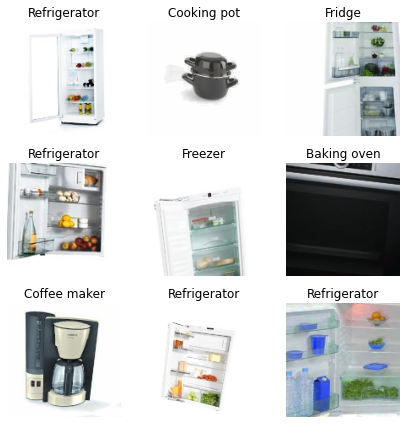

In [39]:
data.show_batch(rows=3, figsize=(6, 6))

In [40]:
print(f'Classes: \n {data.classes}')

Classes: 
 ['Baking oven', 'Coffee maker', 'Cooking pot', 'Espresso machine', 'Freezer', 'Fridge', 'Ironing device', 'Microwave oven', 'Pan', 'Refrigerator', 'hair styler']


In [41]:
print(f"""\
Training set: {len(data.train_ds.x)} images
Validation set: {len(data.valid_ds.x)} images\
"""
)

Training set: 936 images
Validation set: 234 images


Training set: 936 images
Validation set: 234 images


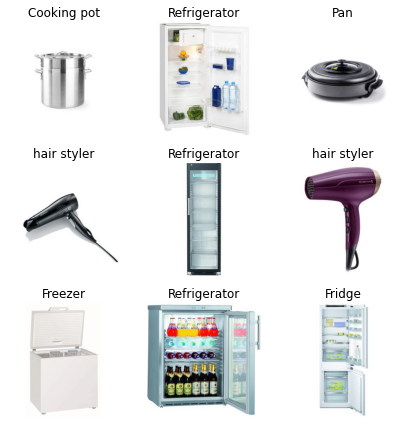

In [6]:
# Load images into fast.ai's ImageDataBunch object
# random.seed(642)
# data = (
#     ImageList.from_folder(DATA_PATH)
#     .split_by_rand_pct(valid_pct=0.2, seed=20)
#     .label_from_folder()
#     .transform(size=IM_SIZE)
#     .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
#     .normalize(imagenet_stats)
# )

# print(f"""\
# Training set: {len(data.train_ds.x)} images
# Validation set: {len(data.valid_ds.x)} images\
# """
# )

# # Display example images
# data.show_batch(rows=3, figsize=(6, 6))

## Classification model fine-tuning

We begin by retrieving a [ResNet18](https://arxiv.org/pdf/1512.03385.pdf) CNN from fast.ai's library which is pre-trained on ImageNet, and fine-tune the model on our training set. We use the same training parameters and take the same approach as what we did in our [classification notebooks](https://github.com/microsoft/ComputerVision/tree/master/classification/notebooks), training first the (new) last layer only, and then the full DNN.

Note how we train the DNN here on an image classification task but will use it as featurizer later for image similarity.

In [42]:
learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
#     callback_fns=[partial(TrainMetricsRecorder, show_graph=True)],
    ps=0 #Leave dropout at zero. Higher values tend to perform significantly worse
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 76.1MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 3.98E-03


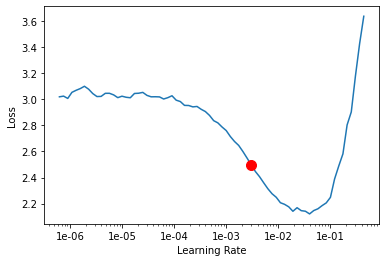

In [43]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [46]:
lr=5e-3
# learn.fit_one_cycle(2, max_lr=slice(1e-2), wd = (1e-6, 1e-4, 1e-2), pct_start=0.5)

In [47]:
# Train the last layer using a larger rate since most of the DNN is fixed.
learn.fit_one_cycle(EPOCHS_HEAD, lr)

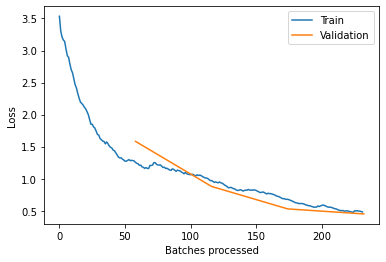

In [48]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 6.31E-06


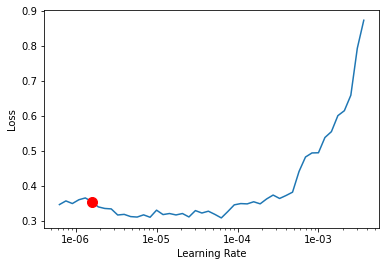

In [49]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

Let's now unfreeze all the layers and fine-tuning the model more 

In [50]:
learn.fit_one_cycle(EPOCHS_BODY, slice(8e-05, lr/5))

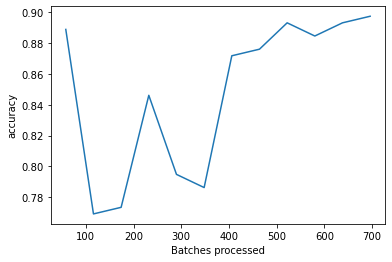

In [51]:
learn.recorder.plot_metrics()

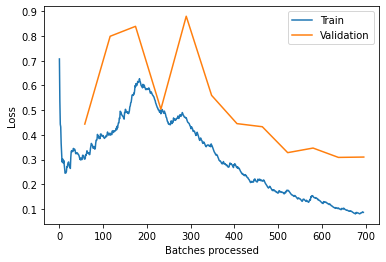

In [52]:
learn.recorder.plot_losses()

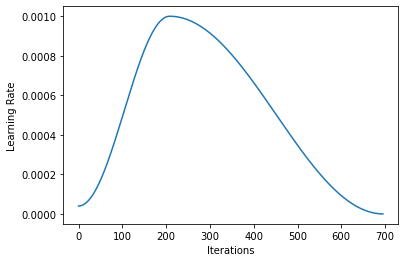

In [53]:
learn.recorder.plot_lr()

In [54]:
data_big = (src.transform(tfms, resize_method=ResizeMethod.SQUISH, padding_mode='reflection', size=IM_SIZE)
        .databunch(bs=BATCH_SIZE, num_workers=db_num_workers())
        .normalize(imagenet_stats))

learn.data = data_big

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.09E-06


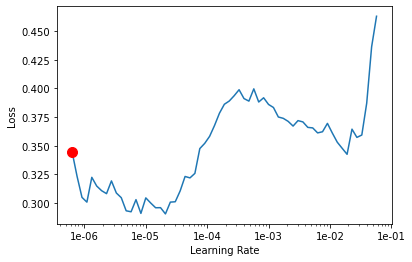

In [55]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [56]:
lr = 4e-6
learn.fit_one_cycle(EPOCHS_HEAD, lr)

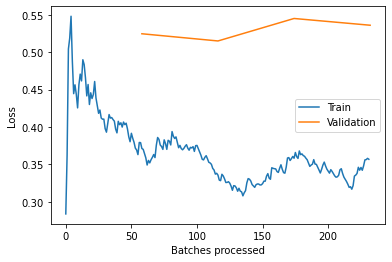

In [58]:
learn.recorder.plot_losses()

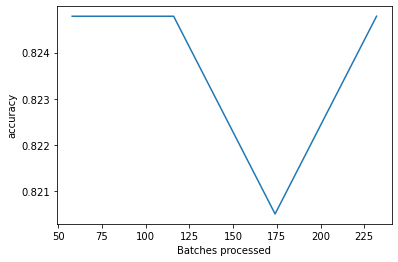

In [59]:
learn.recorder.plot_metrics()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 4.79E-05


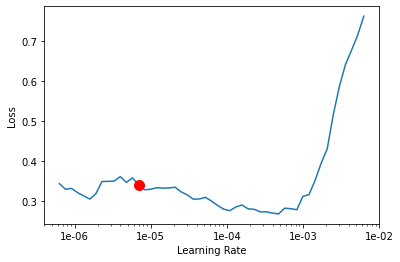

In [61]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [62]:
learn.fit_one_cycle(EPOCHS_BODY, slice(1e-05, lr/5))

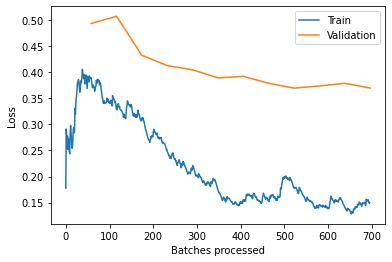

In [63]:
learn.recorder.plot_losses()

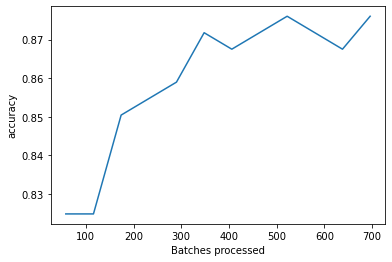

In [64]:
learn.recorder.plot_metrics()

In [65]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data_big.valid_ds)==len(losses)==len(idxs)

True

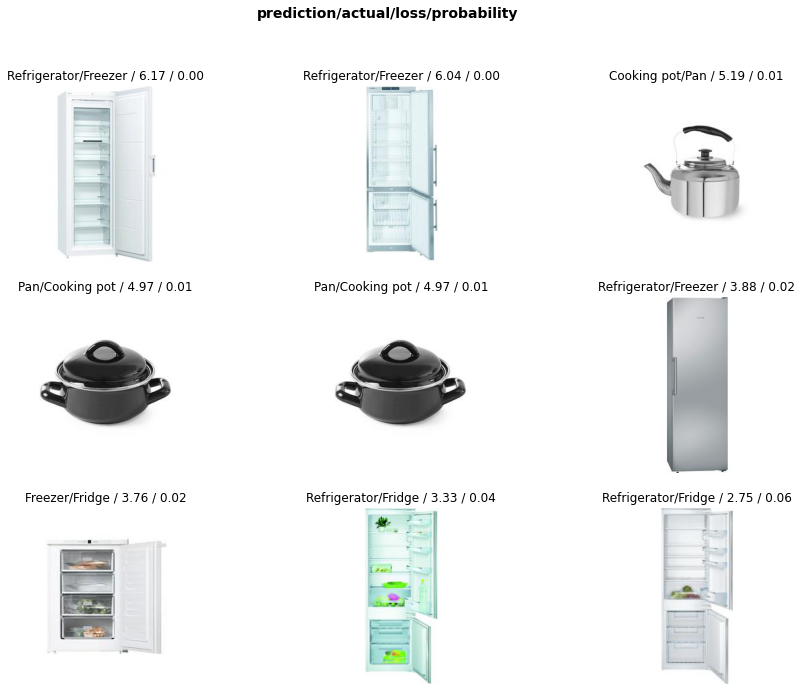

In [66]:
interp.plot_top_losses(9, figsize=(15,11))

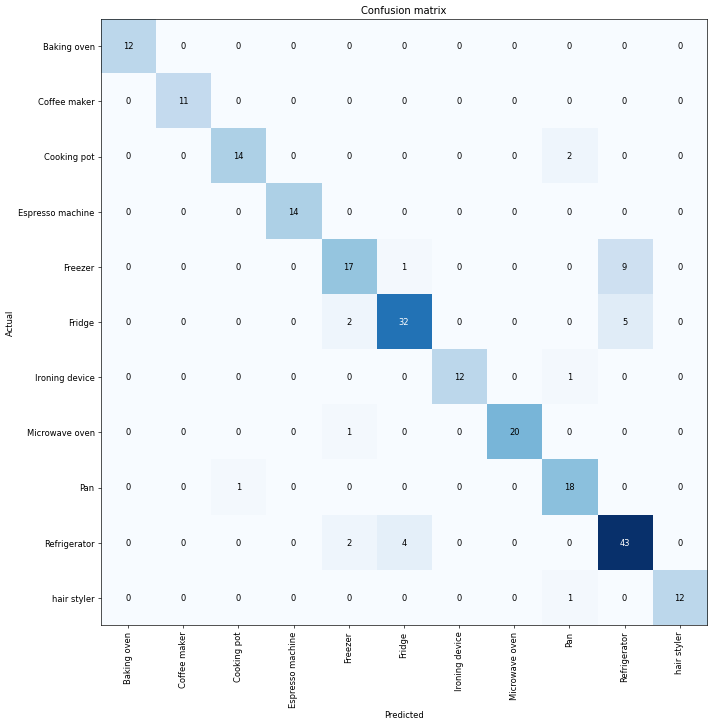

In [67]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [68]:
interp.most_confused(min_val=2)

[('Freezer', 'Refrigerator', 9),
 ('Fridge', 'Refrigerator', 5),
 ('Refrigerator', 'Fridge', 4),
 ('Cooking pot', 'Pan', 2),
 ('Fridge', 'Freezer', 2),
 ('Refrigerator', 'Freezer', 2)]

In [69]:
learn.save('final_model_resnet34_annoy')

In [ ]:
learn.export('final_model_resnet34_annoy')

In [70]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## Fastai Hooks

In [71]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [76]:
learn.model[1][-2] 

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [187]:
sf = SaveFeatures(learn.model[1][4])

In [188]:
_= learn.get_preds(data_big.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [189]:
len(sf.features)

1170

In [190]:
img_path = [str(x) for x in (list(data_big.train_ds.items) +list(data_big.valid_ds.items))]
label = [data_big.classes[x] for x in (list(data_big.train_ds.y.items) +list(data_big.valid_ds.y.items))]
label_id = [x for x in (list(data_big.train_ds.y.items) +list(data_big.valid_ds.y.items))]

In [191]:
len(img_path), len(label), len(label_id)

(1170, 1170, 1170)

In [192]:
df_new = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
# df_new.loc[500:600]
df_new

img_path             label  \
0     /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
1     /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
2     /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
3     /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
4     /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
...                                                 ...               ...   
1165  /home/ec2-user/SageMaker/visual-search-thesis/...           Freezer   
1166  /home/ec2-user/SageMaker/visual-search-thesis/...               Pan   
1167  /home/ec2-user/SageMaker/visual-search-thesis/...       Baking oven   
1168  /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
1169  /home/ec2-user/SageMaker/visual-search-thesis/...  Espresso machine   

      label_id  
0            9  
1            9  
2            9  
3            9  
4            9  
...        ...  
1165         4  
1166         8  
1167         0  
1168         9  
1169         3  

[1170 rows x 3 columns]

In [193]:
array = np.array(sf.features)

In [194]:
x=array.tolist()

In [195]:
df_new['img_repr'] = x

In [196]:
df_new.head()

img_path         label  label_id  \
0  /home/ec2-user/SageMaker/visual-search-thesis/...  Refrigerator         9   
1  /home/ec2-user/SageMaker/visual-search-thesis/...  Refrigerator         9   
2  /home/ec2-user/SageMaker/visual-search-thesis/...  Refrigerator         9   
3  /home/ec2-user/SageMaker/visual-search-thesis/...  Refrigerator         9   
4  /home/ec2-user/SageMaker/visual-search-thesis/...  Refrigerator         9   

                                            img_repr  
0  [0.0, 1.2622718811035156, 0.509613037109375, 0...  
1  [0.0, 0.0, 1.5614043474197388, 5.8252687454223...  
2  [0.0, 0.5316150784492493, 2.7780394554138184, ...  
3  [0.0, 2.338597536087036, 1.7796556949615479, 0...  
4  [0.0, 0.0, 2.0912117958068848, 0.0, 0.0, 16.84...

In [197]:
df_new.shape

(1170, 4)

## Image similarity using Cosine Similarity

In [198]:
from scipy.spatial.distance import cosine
import time

def get_similar_images(img_index, n=10):
    start = time.time()
    base_img_id, base_vector, base_label  = df_new.iloc[img_index, [0, 3, 1]]
    cosine_similarity = 1 - df_new['img_repr'].apply(lambda x: cosine(x, base_vector))
    similar_img_ids = np.argsort(cosine_similarity)[-11:-1][::-1]
    end = time.time()
    print(f'{end - start} secs')
    return base_img_id, base_label, df_new.iloc[similar_img_ids]

In [199]:
base_image, base_label, similar_images_df = get_similar_images(597) # 890

0.1266193389892578 secs


Ironing device
/home/ec2-user/SageMaker/visual-search-thesis/visual-search/data/limmert_data_1/Ironing device/31.jpg


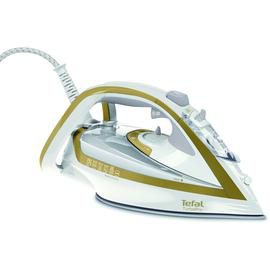

In [200]:
print(base_label)
print(base_image)
open_image(base_image)

In [201]:
similar_images_df

img_path           label  \
603   /home/ec2-user/SageMaker/visual-search-thesis/...  Ironing device   
566   /home/ec2-user/SageMaker/visual-search-thesis/...  Ironing device   
604   /home/ec2-user/SageMaker/visual-search-thesis/...  Ironing device   
1097  /home/ec2-user/SageMaker/visual-search-thesis/...  Ironing device   
1131  /home/ec2-user/SageMaker/visual-search-thesis/...  Ironing device   
563   /home/ec2-user/SageMaker/visual-search-thesis/...  Ironing device   
567   /home/ec2-user/SageMaker/visual-search-thesis/...  Ironing device   
579   /home/ec2-user/SageMaker/visual-search-thesis/...  Ironing device   
576   /home/ec2-user/SageMaker/visual-search-thesis/...  Ironing device   
584   /home/ec2-user/SageMaker/visual-search-thesis/...  Ironing device   

      label_id                                           img_repr  
603          6  [2.9672091007232666, 0.0, 0.0, 11.222708702087...  
566          6  [2.3101401329040527, 0.0, 0.0, 10.270406723022...  
604          6  [4.433164119720459, 0.0, 0.0, 8.11619567871093...  
1097         6  [2.4533305168151855, 0.0, 0.0, 9.4203405380249...  
1131         6  [1.5171306133270264, 0.0, 0.0, 9.2870864868164...  
563          6  [0.9670940041542053, 0.0, 0.0, 8.7799282073974...  
567          6  [2.6461167335510254, 0.0, 0.0, 7.2854189872741...  
579          6  [1.9156581163406372, 0.0, 0.0, 9.4450130462646...  
576          6  [1.4762979745864868, 0.0, 0.0, 10.679725646972...  
584          6  [1.7356072664260864, 0.0, 0.0, 9.7701578140258...

In [202]:
def show_similar_images(similar_images_df):
    images = [open_image(img_id) for img_id in similar_images_df['img_path']]
    categories = [learn.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learn.data.show_xys(images, categories)

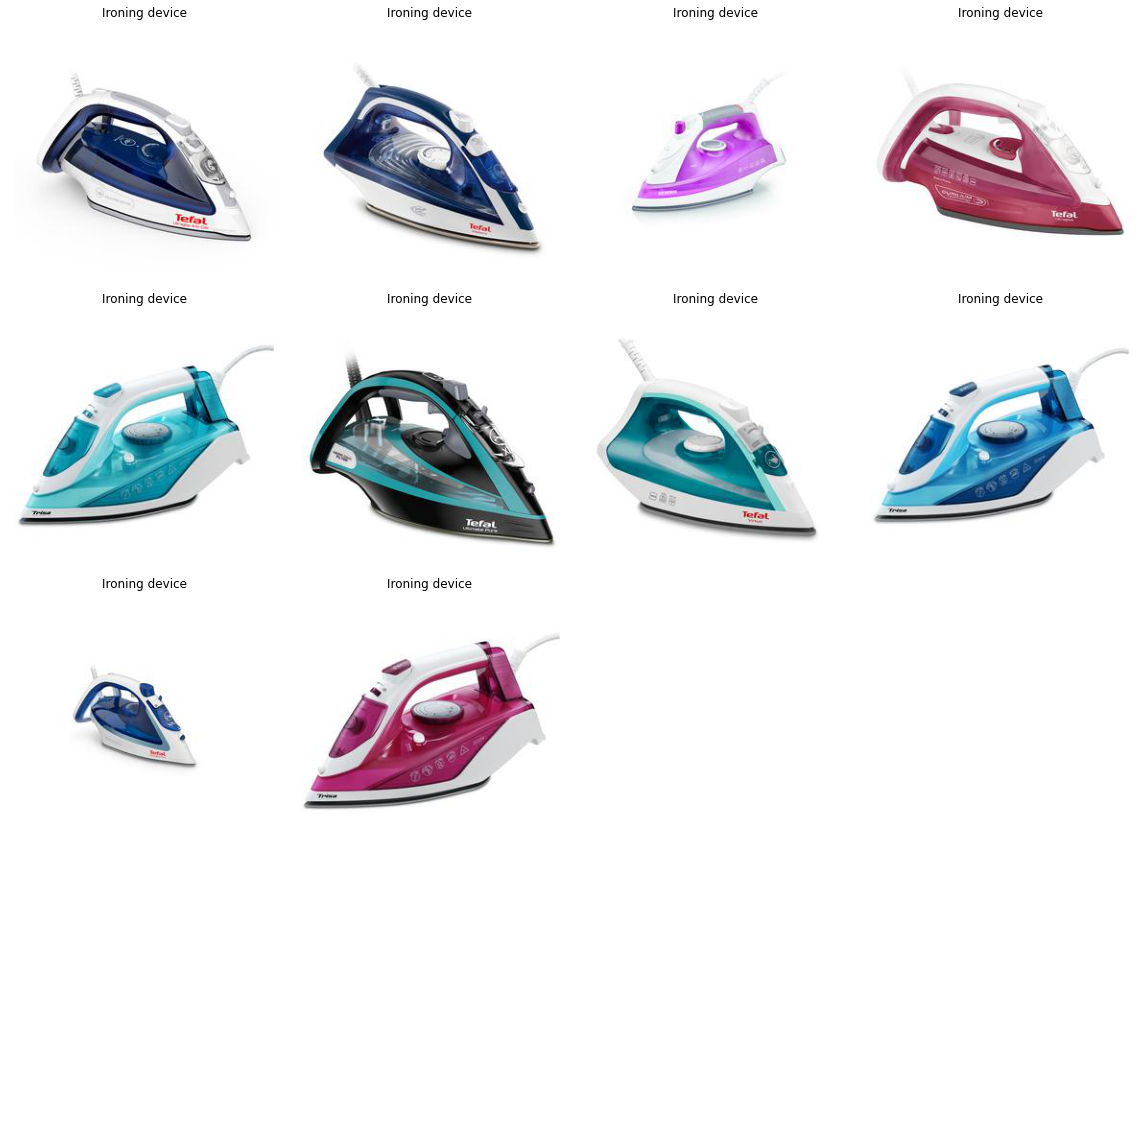

In [203]:
show_similar_images(similar_images_df)

## T-SNE

In [100]:
from sklearn.manifold import TSNE

img_repr_matrix = [list(x) for x in df_new['img_repr'].values]
tsne = TSNE(n_components=3, verbose=10, init='pca', perplexity=30, n_iter=500, n_iter_without_progress=100)
tsne_results_3 = tsne.fit_transform(img_repr_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1170 samples in 0.044s...
[t-SNE] Computed neighbors for 1170 samples in 1.232s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1170
[t-SNE] Computed conditional probabilities for sample 1170 / 1170
[t-SNE] Mean sigma: 12.262047
[t-SNE] Computed conditional probabilities in 0.086s
[t-SNE] Iteration 50: error = 63.1783066, gradient norm = 0.1073865 (50 iterations in 1.355s)
[t-SNE] Iteration 100: error = 60.6088295, gradient norm = 0.0920249 (50 iterations in 1.028s)
[t-SNE] Iteration 150: error = 63.6512222, gradient norm = 0.0724242 (50 iterations in 1.093s)
[t-SNE] Iteration 200: error = 63.1045074, gradient norm = 0.0541850 (50 iterations in 1.136s)
[t-SNE] Iteration 250: error = 62.5210114, gradient norm = 0.0556732 (50 iterations in 1.144s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.521011
[t-SNE] Iteration 300: error = 0.8502852, gradient norm = 0.0010494 (50 iterations in 1.598s

In [101]:
df_new['tsne1'] = tsne_results_3[:,0]
df_new['tsne2'] = tsne_results_3[:,1]
df_new['tsne3'] = tsne_results_3[:,2]

In [102]:
df_new.to_parquet('similar_images')

In [104]:
pip install plotly_express

     |████████████████████████████████| 13.1 MB 12.9 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 49.4 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 37.8 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=9c6fa6f4a1e1362cb7454e13523be2b8fbc1efe3d048448d5557f27b7d471193
  Stored in directory: /home/ec2-user/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


In [105]:
import plotly_express as px
px.scatter_3d(df_new, x='tsne1', y='tsne2', z='tsne3', color='label')

In [123]:
# Use penultimate layer as image representation
embedding_layer = learn.model[1][-2] 
print(embedding_layer)

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [124]:
#Compute DNN features for all validation images
valid_features = compute_features_learner(data, DatasetType.Valid, learn, embedding_layer)

## Image Retrieval Example
The cell below shows how to find and display the most similar images in the validation set for a given query image (which we also select from the validation set). This example is similar to the one shown in the [00_webcam.ipynb](https://github.com/microsoft/ComputerVision/tree/master/similarity/notebooks/00_webcam.ipynb) notebook. 

We use the L2 distance which is defined as <sup> $ \sqrt{\sum_{i=1}^{n}{(F_{q}[i] - F_{r}[i])^{2}}} $ </sup> where $F_{q}$ and $F_{r}$ are the features of a query image and a reference image respectively, and $n=512$ is their dimensionality. By default, we normalize the feature vectors $F_{q}$ and $F_{r}$ to be unit-length, i.e. have a magnitude ||$F$|| of 1, before computing the L2 distance. One could also use other distances measures, such as L1 or cosine similarity, however L2 with unit-length normalized feature vectors seems to work well in practice. 

Query image path: /home/ec2-user/SageMaker/visual-search-thesis/visual-search/data/limmert_data_1/Coffee maker/92.jpg
Query feature dimension: 512


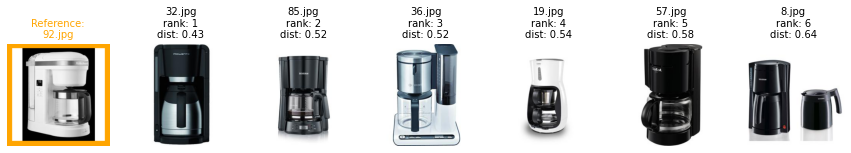

In [125]:
# Get the DNN feature for the query image
query_im_path =  str(data.valid_ds.items[3])
query_feature = valid_features[query_im_path]
print(f"Query image path: {query_im_path}")
print(f"Query feature dimension: {len(query_feature)}")
assert len(query_feature) == 512

# Compute the distances between the query and all reference images
distances = compute_distances(query_feature, valid_features)
plot_distances(distances, num_rows=1, num_cols=7, figsize=(15,5))

In [127]:
w_results = RetrievalWidget(
    ds=data.valid_ds,
    features=valid_features,
    rows=2,
    cols=5,
)
display(w_results.show())

## Quantitative evaluation

To measure accuracy of our image retrieval system, we create so called `comparative sets` from the validation images. Each comparative set consists of a `query` image, a `positive` image (with the same label as the query image), and 99 `negative` images (different label). When sorting the 101 reference images according to their distance to the query image, a perfect image similarity system would place the positive image at the top before all negative images i.e. at rank 1. 


### Comparative sets creation

In the cell below, we construct 1000 comparative sets from the validation set, each with 99 negative images (and one positive image).

In [128]:
# Build multiple sets of comparative images from the validation images
comparative_sets = comparative_set_builder(data.valid_ds, num_sets = 1000, num_negatives = 99)
print(f"Generated {len(comparative_sets)} comparative image sets.")

Generated 1000 comparative image sets.


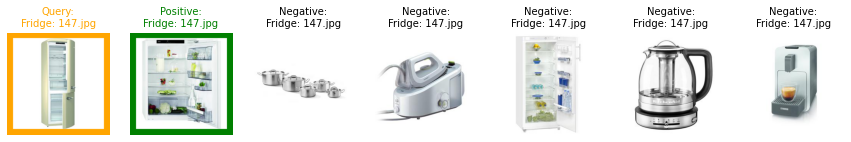

In [129]:
# Plot the query image, the positive image, and some of the negative images of the first comparative set
plot_comparative_set(comparative_sets[3], 7, figsize=(15,5))

In [130]:
# For each comparative set compute the distances between the query image and all reference images
for cs in comparative_sets:
    cs.compute_distances(valid_features)

### Evaluation

To measure accuracy of our image retrieval system, we compute these two statistics:
- Median rank: median rank of the positive example across all comparative sets. A value of 1 being best, 100 worst, and 50 random chance guessing.
- Recall at k: percentage of positive examples within the top k, ie. with rank <= k. A value of 100% being best, 0% worst, and at k=1 or k=5 random chance guessing of 1% or 5% respectively.

In [131]:
# Compute the median rank of the positive example over all comparative sets
ranks = positive_image_ranks(comparative_sets)
median_rank = np.median(ranks)
random_rank = np.median([(len(cs.neg_im_paths)+1)/2.0 for cs in comparative_sets])
print(f"The positive example ranks {median_rank}, as a median, \
across our {len(ranks)} comparative sets. Random chance rank is {random_rank}")

The positive example ranks 1.0, as a median, across our 1000 comparative sets. Random chance rank is 50.0


The positive image is:
 --> 52.1% of the time the most similar to the query
 --> 67.7% of the time in the top 5 images
 --> 76.2% of the time in the top 10 images


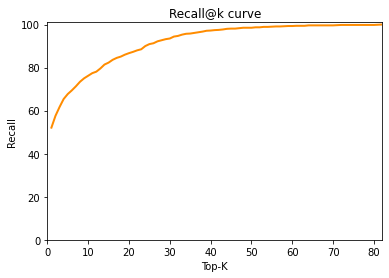

In [132]:
# Compute recall at k=1, 5, and 10
print(f"""The positive image is:
 --> {recall_at_k(ranks, 1)}% of the time the most similar to the query
 --> {recall_at_k(ranks, 5)}% of the time in the top 5 images
 --> {recall_at_k(ranks, 10)}% of the time in the top 10 images""")

# Plot recall versus k
plot_recalls(ranks)

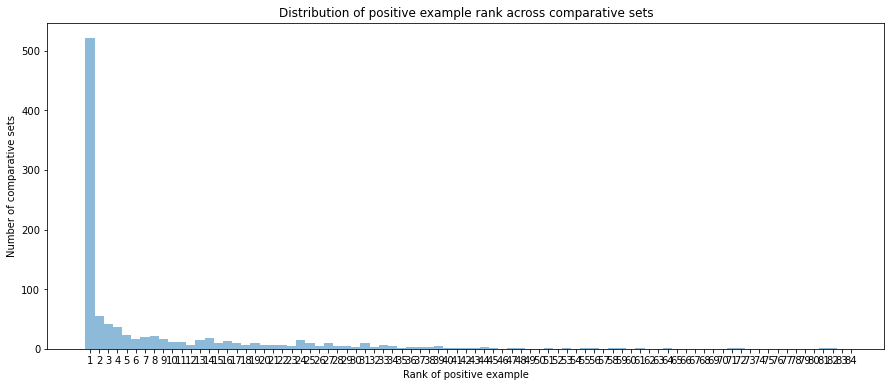

In [133]:
# Display the distribution of positive ranks among the comparative sets
plot_ranks_distribution(ranks)

In [134]:
# Write trained model to disk
learn.save("stage-2-270-resnet34_annoy")
learn.export("stage-2-270-resnet34_annoy")
print(f"Exported model to directory {learn.path}")

Exported model to directory /home/ec2-user/SageMaker/visual-search-thesis/visual-search/data/limmert_data_1


## Fine-tuning parameters <a name="finetuning"></a>

Using the provided default parameters, one can get good results across a wide variety of datasets. However, as in most machine learning projects, getting the best possible results for a new dataset often requires tuning the parameters further. 

See the image classification [03_training_accuracy_vs_speed.ipynb](../../classification/notebooks/03_training_accuracy_vs_speed.ipynb) notebook for guidelines on optimizing for accuracy, inference speed, or model size for a given dataset. In addition, the notebook also goes through the parameters that will make the largest impact on your model as well as the parameters that may not be worth modifying.

The notebook [11_exploring_hyperparameters.ipynb](11_exploring_hyperparameters.ipynb) in this directory is provided to run  run sweeps to find the parameters with best possible image retrieval (ie rank) performance. Below is an example where, to identify good default parameters for this repository, different learning rates where tried on diverse datasets. Note that lower ranks is better, and learning rates between $1e-4$ and $1e-3$ performed best.
<img src="media/sweep_learning_rates.jpg" width="600px" />


In [33]:
# Log some outputs using scrapbook which are used during testing to verify correct notebook execution
sb.glue("median_rank", median_rank)
sb.glue("random_rank", random_rank)